In [ ]:
# Imports
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import numpy as np
import glob
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import PIL
from PIL import ImageFile, Image
ImageFile.LOAD_TRUNCATED_IMAGES = True
import pathlib
from tqdm import tqdm

In [ ]:
'''
Visit kaggle to download dataset. Zip files and upload to Drive as 'collab.zip'
'''

In [ ]:
# Do not run again once obtained zip file
# Login to GoogeDrive to retrieve uploaded .zip file
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
# DO not run again after unzipped zip file
# Get shareable link and obtain file id
downloaded = drive.CreateFile({'id': '1pt65QhAmeULlhIv-ufHUBbSQ7CXlldLY'})
downloaded.GetContentFile('collab.zip')
!unzip collab.zip

Archive:  collab.zip
   creating: collab/
  inflating: collab/.DS_Store        
  inflating: __MACOSX/collab/._.DS_Store  
   creating: collab/non_fire_images/
  inflating: __MACOSX/collab/._non_fire_images  
   creating: collab/fire_images/
  inflating: __MACOSX/collab/._fire_images  
  inflating: collab/non_fire_images/non_fire.134.png  
  inflating: __MACOSX/collab/non_fire_images/._non_fire.134.png  
  inflating: collab/non_fire_images/non_fire.120.png  
  inflating: __MACOSX/collab/non_fire_images/._non_fire.120.png  
  inflating: collab/non_fire_images/non_fire.108.png  
  inflating: __MACOSX/collab/non_fire_images/._non_fire.108.png  
  inflating: collab/non_fire_images/non_fire.242.png  
  inflating: __MACOSX/collab/non_fire_images/._non_fire.242.png  
  inflating: collab/non_fire_images/non_fire.47.png  
  inflating: __MACOSX/collab/non_fire_images/._non_fire.47.png  
  inflating: collab/non_fire_images/non_fire.53.png  
  inflating: __MACOSX/collab/non_fire_images/._non_fire.

In [ ]:
# Check that it worked - should now be a 'collab' file bc you unzipped 'collab.zip'
!ls

adc.json  collab  collab.zip  __MACOSX	sample_data


In [ ]:
# Define path to data
data_dir = '/content/collab' 
fire_dir = f'{data_dir}/fire_images'
notfire_dir = f'{data_dir}/non_fire_images'

In [ ]:
# Get list of fire images
fire_images = []
for filename in glob.glob(f'{fire_dir}/*.png'):
    im=Image.open(filename)
    fire_images.append(im)

In [ ]:
# Get list of non fire iamges
non_fire_images = []
for filename in glob.glob(f'{notfire_dir}/*.png'):
    im=Image.open(filename)
    non_fire_images.append(im)

In [ ]:
# Inspect for class imbalance
len(fire_images), len(non_fire_images)

(755, 244)

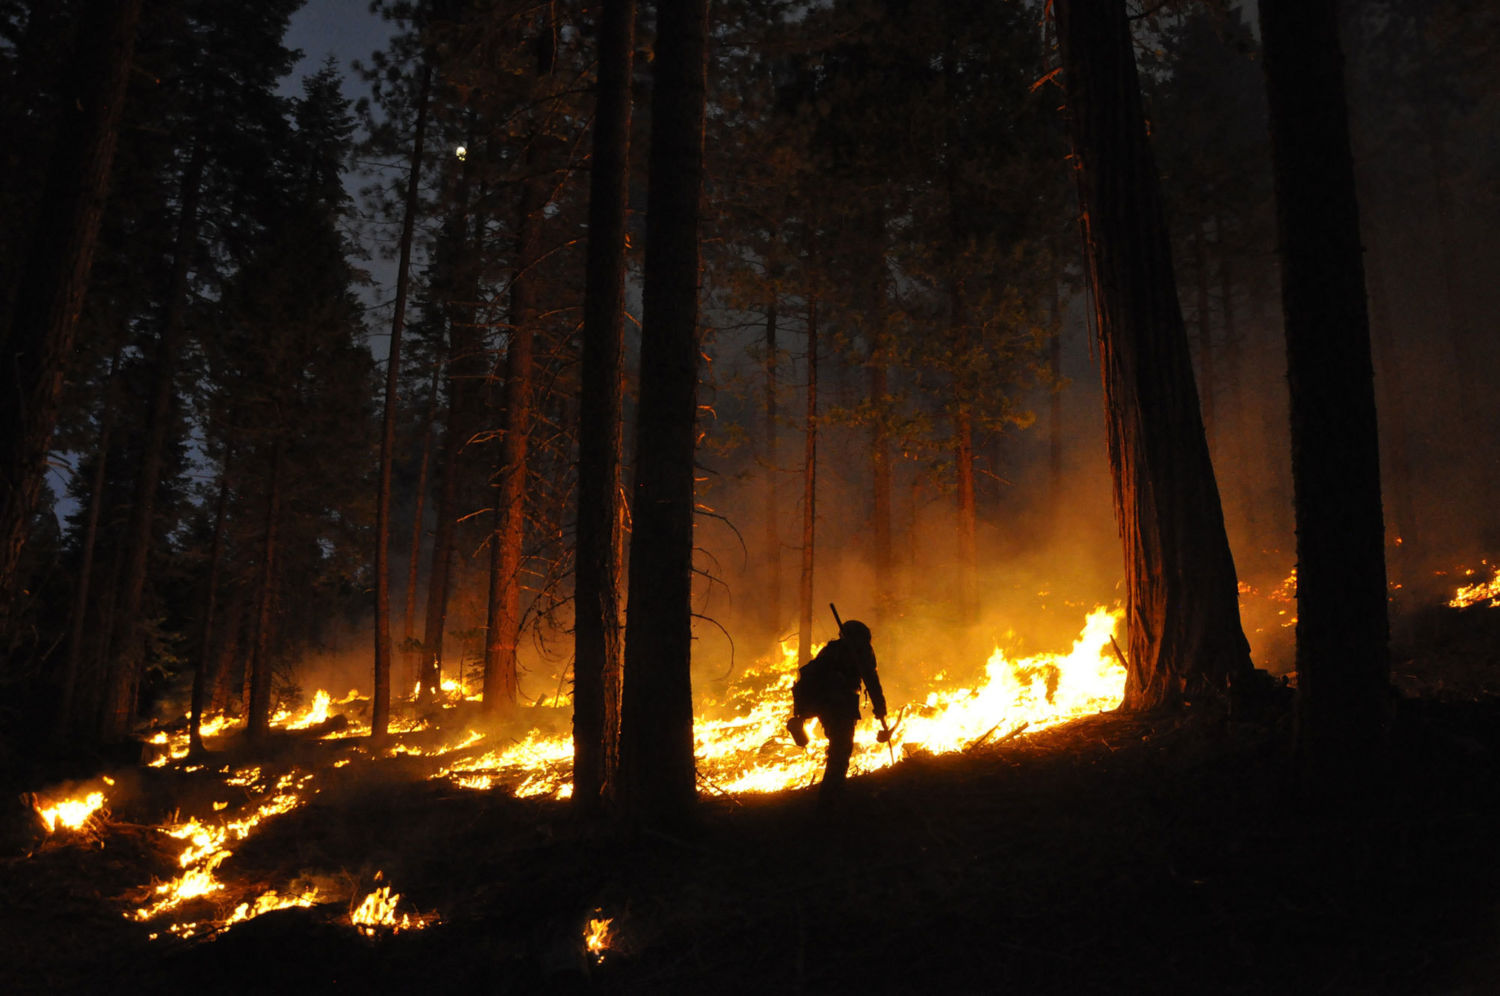

In [ ]:
fire_images[0]

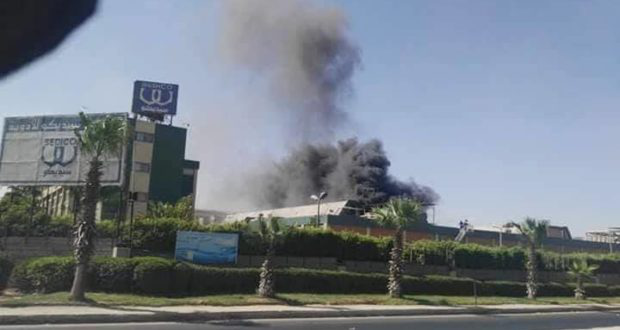

In [ ]:
non_fire_images[0]

In [ ]:
# Generate images to balance classes
datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

def gen_images(path, num, fire):
    '''
    Reads in image, coverts to array, reshapes, applies datagen 4 times.
    Repeats num times.
    '''
    if fire:
        for i in tqdm(range(1, num+1)):
            
            img = Image.open(f'{path}/fire.{i}.png')
            x = img_to_array(img)
            x = x.reshape((1,) + x.shape)
            i=0
            for batch in datagen.flow(x, batch_size=1, save_to_dir=f'{path}/', save_prefix='fire', save_format='png'):
                i += 1
                if i > 20:
                    break
    else:
        for i in tqdm(range(1, num+1)):
            img = Image.open(f'{path}/non_fire.{i}.png')
            x = img_to_array(img)
            x = x.reshape((1,) + x.shape)
            i=0
            for batch in datagen.flow(x, batch_size=1, save_to_dir=f'{path}/', save_prefix='non_fire', save_format='png'):
                i += 1
                if i > 4:
                    break

In [ ]:
# Do not run again once already ran
# Generate 4x 125 augmented non fire images
gen_images(notfire_dir, 120, fire=False)

100%|██████████| 120/120 [13:32<00:00,  6.77s/it]


In [ ]:
# Check that it worked
# Get list of non fire iamges
non_fire_images = []
for filename in glob.glob(f'{notfire_dir}/*.png'):
    im=Image.open(filename)
    non_fire_images.append(im)

In [ ]:
len(non_fire_images)

830

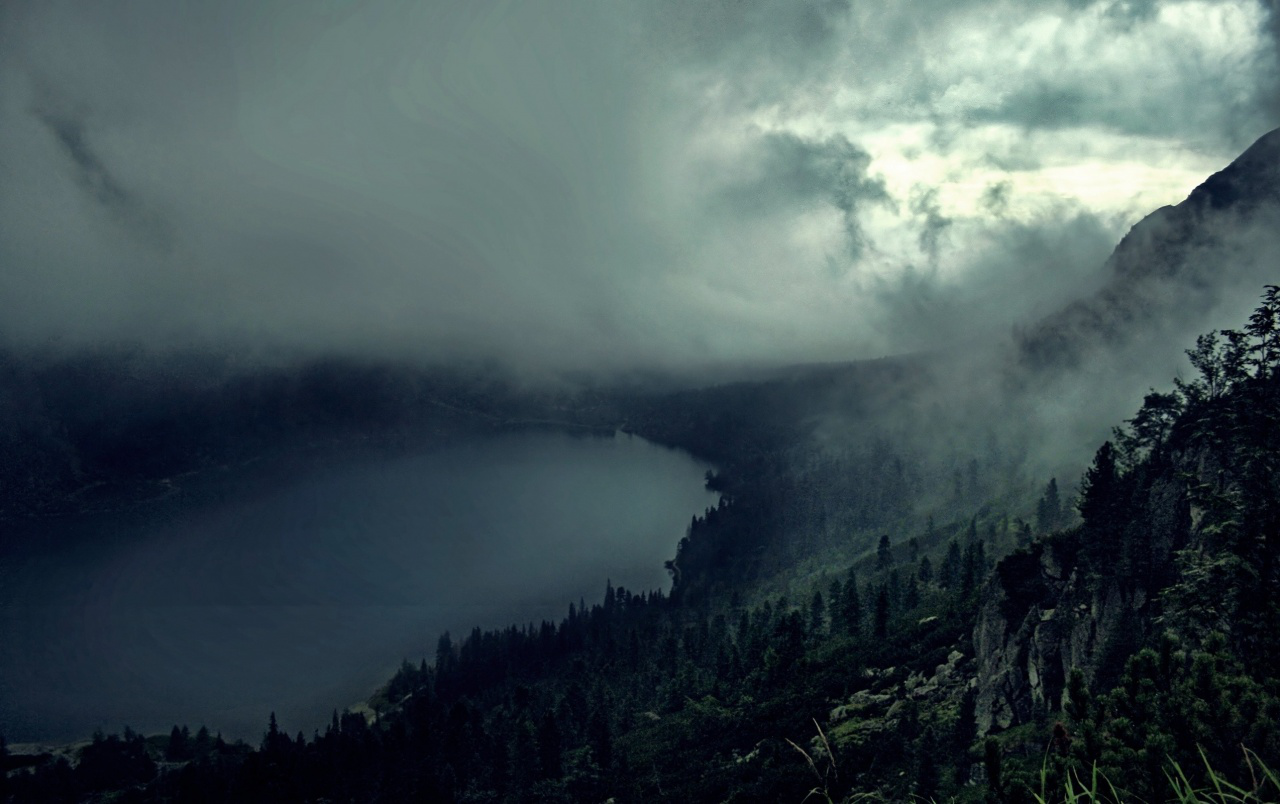

In [ ]:
non_fire_images[500]

In [ ]:
batch_size = 16
img_height = 256
img_width = 256
epochs=50

In [ ]:
X_train = image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  shuffle=True,
  image_size=(img_height, img_width),
  batch_size=batch_size)

X_test = image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1585 files belonging to 2 classes.
Using 1268 files for training.
Found 1585 files belonging to 2 classes.
Using 317 files for validation.


Found 1613 files belonging to 2 classes.
Using 322 files for validation.
tf.Tensor([0 0 1 1 1 1 1 0 1 1 1 0 1 0 0 1], shape=(16,), dtype=int32)


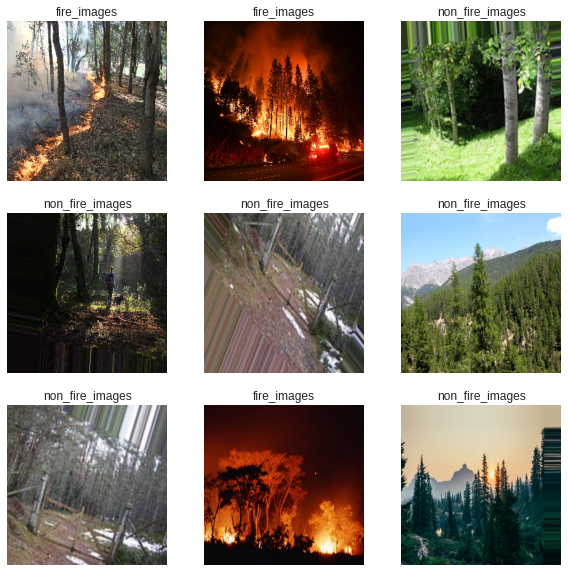

In [ ]:
# Looking at the images and their labels in our test generator
class_names = X_test.class_names

plt.figure(figsize=(10, 10))
for images, labels in X_test.take(1):
  print(labels)
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")
plt.savefig('test_image_examples.jpeg')

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
#The buffer_size in Dataset.shuffle() can affect the randomness of your dataset, and hence the order in which elements are produced.
#The buffer_size in Dataset.prefetch() only affects the time it takes to produce the next element.
X_train = X_train.cache().repeat().shuffle(16).prefetch(buffer_size=AUTOTUNE)
X_test = X_test.cache().repeat().prefetch(buffer_size=AUTOTUNE)

Model loaded.
Weights Checkpoint Defined.
Epoch 1/50
10/10 [==============================] - ETA: 0s - loss: 49.7748 - accuracy: 0.5562
Epoch 00001: val_accuracy improved from -inf to 0.46875, saving model to m1_bestweights.hdf5
10/10 [==============================] - 32s 3s/step - loss: 49.7748 - accuracy: 0.5562 - val_loss: 2.6109 - val_accuracy: 0.4688
Epoch 2/50
10/10 [==============================] - ETA: 0s - loss: 2.2641 - accuracy: 0.5813
Epoch 00002: val_accuracy improved from 0.46875 to 0.54375, saving model to m1_bestweights.hdf5
10/10 [==============================] - 32s 3s/step - loss: 2.2641 - accuracy: 0.5813 - val_loss: 0.7572 - val_accuracy: 0.5437
Epoch 3/50
10/10 [==============================] - ETA: 0s - loss: 0.7487 - accuracy: 0.6187
Epoch 00003: val_accuracy improved from 0.54375 to 0.75000, saving model to m1_bestweights.hdf5
10/10 [==============================] - 31s 3s/step - loss: 0.7487 - accuracy: 0.6187 - val_loss: 0.5691 - val_accuracy: 0.7500
Ep

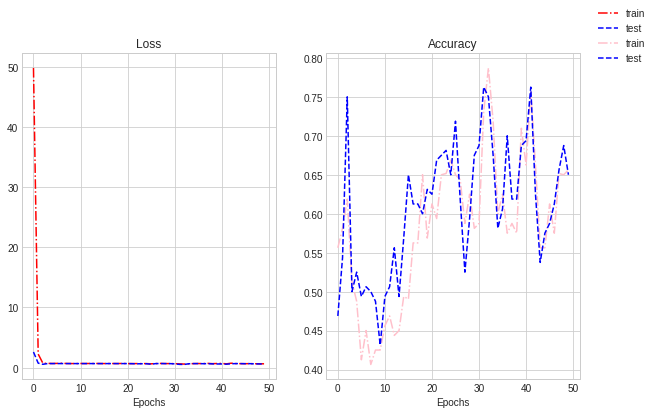

In [ ]:
# CNN Model 1
# Note: if you run this cell more than once, you will want to rename:
# weights originally named 'm1_bestweights.hdf5'
# model originally named 'm1.h5'
# loss & accuracy plot originally named: 'm1_loss_acc.jpeg'

def model1():
    model = Sequential()
    model.add(Conv2D(32, (3,3), input_shape=(img_height, img_width, 3))) 
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Conv2D(32, (3,3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Conv2D(64, (3,3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Flatten())
    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dropout(0.8))
    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    
    model.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])
    
    return model
   
model = model1()
print('Model loaded.')

checkpoint = ModelCheckpoint(
            filepath='m1_bestweights.hdf5',
            monitor = 'val_accuracy',
            verbose=1,
            save_best_only=True)
print('Weights Checkpoint Defined.')

history = model.fit(
            X_train,
            steps_per_epoch=10,
            epochs=epochs,
            callbacks=[checkpoint],
            validation_data=X_test,
            validation_steps=10)
print('Model Trained.')

model.summary()

model.save('m1.h5')

#model.evaluate(X_test)

fig, ax = plt.subplots(1, 2, figsize=(10,6))

ax[0].plot(history.history['loss'], label='train', linestyle='-.', color='red')
ax[0].plot(history.history['val_loss'], label='test', linestyle='--', color='blue')
ax[0].set_title('Loss')
ax[0].set_xlabel('Epochs')
ax[1].plot(history.history['accuracy'], label='train', linestyle='-.', color='pink')
ax[1].plot(history.history['val_accuracy'], label='test',linestyle='--', color='blue')
ax[1].set_title('Accuracy')
ax[1].set_xlabel('Epochs')
fig.legend()
fig.show() 
fig.savefig('m1_loss_acc.jpeg')
    

In [ ]:
'''
Load model.

Plots 6 images.
'''
def model_evaluate_val(ax, model, batch_size=1):
    X_test = image_dataset_from_directory(
      data_dir,
      validation_split=0.2,
      subset="validation",
      seed=123,
      shuffle=True,
      image_size=(256, 256),
      batch_size=batch_size)

    print(model.evaluate(X_test))

    images = []
    results = []
    labels = []

    for i, (image, label) in enumerate(X_test.take(6)):
      prediction = model.predict(image)

      if (prediction < 0.5) != label:
        result = 'Correct'
      else:
        result = 'Incorrect'

      results.append(result)
      labels.append(label)
      
      images.append(image[0].numpy().astype("uint8"))
      if i > 4: break
    print('Results stored.')
    labels = ['FIRE' if label==0 else 'So not fire' for label in labels]
    print('Labels updated.')    
    for i, (label, result, image) in enumerate(zip(labels, results, images)):
        ax[i//3, i%3].imshow(image)
        ax[i//3, i%3].axis('off')
        ax[i//3, i%3].set_title('{}, Predicted {}'.format(label, result))
    return ax

In [ ]:
model = load_model('m1.h5')
print('Model loaded.')

fig, ax = plt.subplots(2,3, figsize=(10,6))
fig.subplots_adjust(wspace=.05)

model_evaluate_val(ax, model)

fig.savefig('m1_predictions.jpeg')

In [ ]:
from sklearn.metrics import roc_curve, auc, confusion_matrix, f1_score

def plot_roc(ax, model, threshold=0.5):

  X_test2 = image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=1234,
    image_size=(img_height, img_width),
    batch_size=16)

  #print(model.evaluate(X_test2))

  y = np.concatenate([y for x, y in X_test2], axis=0)
  predictions = model.predict(X_test2, verbose=2)
  y_pred = predictions.ravel()
  y_pred = y_pred < threshold
  fpr, tpr, thresholds = roc_curve(y, y_pred, pos_label=1)
  auc_ = auc(fpr, tpr)
  print(confusion_matrix(y, y_pred))

  ax.plot([0, 1], [0, 1], 'k--')
  ax.plot(fpr, tpr, label='Keras (area = {:.3f})'.format(auc_))
  ax.set_xlabel('False positive rate')
  ax.set_ylabel('True positive rate')
  ax.set_title('ROC curve')

  return ax

In [ ]:
model = load_model('m1.h5')

fig, ax = plt.subplots(figsize=(10,10))

ax = plot_roc(ax, model)

fig.show()
fig.savefig('m1_roccurve.jpeg')

Model loaded.
Model compiled.
Weights Checkpoint Defined.
Early stopping and model checkpoint defined.
Epoch 1/50
10/10 [==============================] - ETA: 0s - loss: 0.9717 - accuracy: 0.5375
Epoch 00001: val_accuracy improved from -inf to 0.63750, saving model to m2_bestweights.hdf5

Epoch 00001: val_accuracy improved from -inf to 0.63750, saving model to m2.h5
10/10 [==============================] - 55s 6s/step - loss: 0.9717 - accuracy: 0.5375 - val_loss: 0.6921 - val_accuracy: 0.6375
Epoch 2/50
10/10 [==============================] - ETA: 0s - loss: 0.6130 - accuracy: 0.6375
Epoch 00002: val_accuracy did not improve from 0.63750

Epoch 00002: val_accuracy did not improve from 0.63750
10/10 [==============================] - 52s 5s/step - loss: 0.6130 - accuracy: 0.6375 - val_loss: 0.5946 - val_accuracy: 0.5750
Epoch 3/50
10/10 [==============================] - ETA: 0s - loss: 0.5275 - accuracy: 0.7250
Epoch 00003: val_accuracy improved from 0.63750 to 0.73750, saving model 

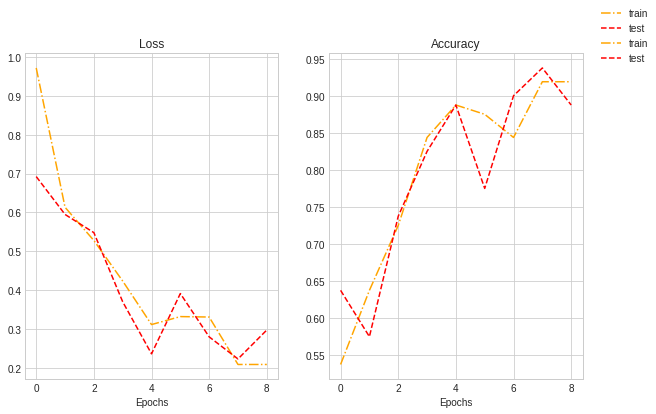

In [ ]:
# CNN Model 2 with 3x layers of 0.5 Dropout
# Note: if you run this cell more than once, you will want to rename:
  # weights originally named 'm2_bestweights.hdf5'
  # model originally named 'm2.h5'
  # loss & accuracy plot originally named: 'm2_loss_acc.jpeg'

def model2():
  model = Sequential([
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.Conv2D(16, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.5),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.5),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.5),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid', name='visualized_layer')
  ])
  return model

model = model2()
print('- - -> Model loaded.')

model.compile(loss='binary_crossentropy',
        optimizer='adam',
        metrics=['accuracy'])
print('- - - - -> Model compiled.')

checkpoint = ModelCheckpoint(
            filepath='m2_bestweights.hdf5',
            monitor = 'val_accuracy',
            verbose=1,
            save_best_only=True)
print('- - - - - - -> Weights checkpoint defined.')

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=25)
mc = ModelCheckpoint('m2.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
print('- - - - -> Early stopping and model checkpoint defined.')

history = model.fit(
            X_train,
            steps_per_epoch=10,
            epochs=epochs,
            callbacks=[checkpoint, es, mc],
            validation_data=X_test,
            validation_steps=5)
print('- - -> Model trained.')

print(model.summary())

model.save('m2.h5')

fig, ax = plt.subplots(1,2, figsize=(10,6))
ax[0].plot(history.history['loss'], label='train', linestyle='-.', color='orange')
ax[0].plot(history.history['val_loss'], label='test', linestyle='--', color='red')
ax[0].set_title('Loss')
ax[0].set_xlabel('Epochs')
ax[1].plot(history.history['accuracy'], label='train', linestyle='-.', color='orange')
ax[1].plot(history.history['val_accuracy'], label='test',linestyle='--', color='red')
ax[1].set_title('Accuracy')
ax[1].set_xlabel('Epochs')
fig.legend()
fig.savefig('m2_loss_acc.jpeg')


Model loaded.
Found 1585 files belonging to 2 classes.
Using 317 files for validation.
317/317 [==============================] - 36s 114ms/step - loss: 0.1853 - accuracy: 0.9243
[0.18531173467636108, 0.9242902398109436]
Results stored.
Labels updated.


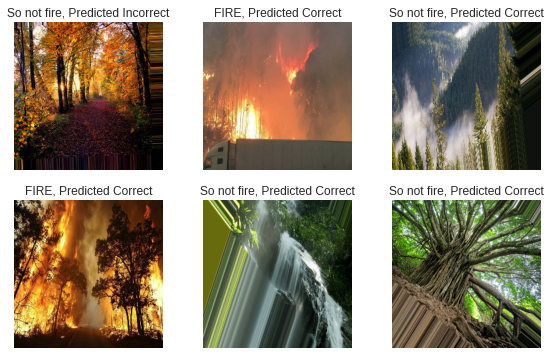

In [ ]:
model = load_model('m2.h5')
print('Model loaded.')

fig, ax = plt.subplots(2,3, figsize=(10,6))
fig.subplots_adjust(wspace=.05)

model_evaluate_val(ax, model)

fig.savefig('m2_predictions.jpeg')

Found 1585 files belonging to 2 classes.
Using 317 files for validation.
20/20 - 24s
[[91 61]
 [88 77]]


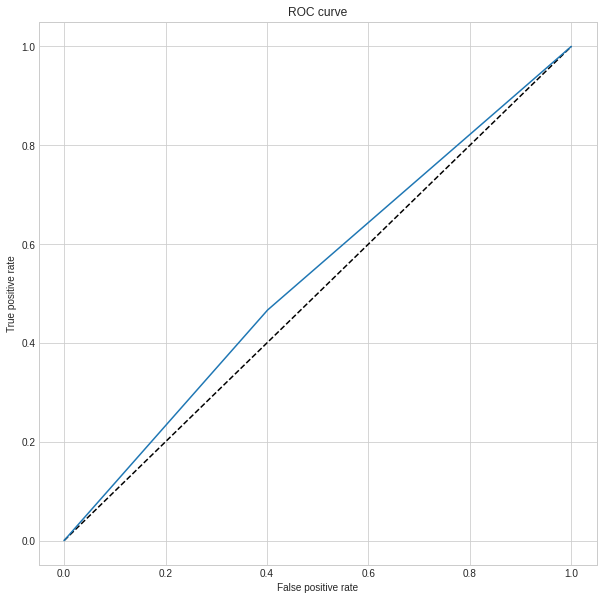

In [ ]:
model = load_model('m2.h5')

fig, ax = plt.subplots(figsize=(10,10))

ax = plot_roc(ax, model)

fig.show()
fig.savefig('m2_roccurve.jpeg')

In [ ]:
def labels(pos_probs, threshold):
	return (pos_probs < threshold).astype('int')

In [ ]:
def tune_threshold(model):
  X_test2 = image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=16)

  print(model.evaluate(X_test2))

  y = np.concatenate([y for x, y in X_test2], axis=0)
  yhat = model.predict(X_test2, verbose=2)

  thresholds = np.arange(0, 1, 0.001)
  
  scores = [f1_score(y, labels(yhat, t)) for t in thresholds]

  ix = np.argmax(scores)
  print(f'Index={ix}, Threshold={thresholds[ix]}, F-Score={scores[ix]}')
  
  return thresholds[ix], scores[ix]

Found 1585 files belonging to 2 classes.
Using 317 files for validation.
20/20 [==============================] - 25s 1s/step - loss: 0.1853 - accuracy: 0.9243
[0.18531179428100586, 0.9242902398109436]
20/20 - 24s
Index=0, Threshold=0.0, F-Score=0.6846473029045643
Found 1585 files belonging to 2 classes.
Using 317 files for validation.
20/20 - 24s
[[152   0]
 [165   0]]


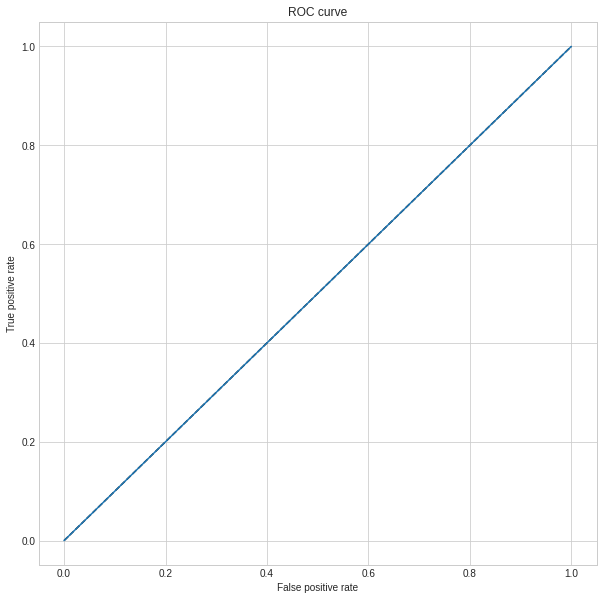

In [ ]:
model = load_model('m2.h5')

threshold, score = tune_threshold(model)

fig, ax = plt.subplots(figsize=(10,10))

ax = plot_roc(ax, model, threshold=threshold)

fig.show()
fig.savefig('m2_roccurve_optimalthreshold.jpeg')

In [ ]:
# From this point on, code does not work and further research is required *

In [ ]:
    class_names = X_test2.class_names
    print('Saved class names.')
    ypred = model.predict(X_test)
    yclass = [class_names[0] if ]
    yclass = model.predict_classes(X_test)
    print(confusion_matrix(X_train.classes,yclass))
    print(roc_auc_score(X_train.classes, ypred))

Saved class names.
Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


AttributeError: ignored

In [ ]:
class_names

['fire_images', 'non_fire_images']

In [ ]:
from vis.visualization import visualize_activation
from vis.utils import utils
import matplotlib.pyplot as plt

ImportError: ignored

In [ ]:
model = load_model('colab_model.h5')
print('Model loaded.')

# get index of visualized layer
layer_index = utils.find_layer_idx(model, 'visualized_layer')

# Swap sigmoid with linear
#model.layers[layer_index].activation = activations.linear
#model = utils.apply_modifications(model)  

# only two classes: fire or not fire
classes_to_visualize = [0, 1]
classes = {
  0: 'Fire',
  1: 'Not Fire'
}

# Visualize
for number_to_visualize in classes_to_visualize:
  visualization = visualize_activation(model, layer_index, filter_indices=number_to_visualize, input_range=(0., 1.))
  plt.imshow(visualization)
  plt.title('Target = {}'.format(classes[number_to_visualize]))
  plt.show()

opt = Optimizer(model.input, losses)
opt.minimize(max_iter=500, verbose=True, input_modifiers=[Jitter()], callbacks=[GifGenerator('opt_progress')])

Model loaded.


NameError: ignored